## 1. Subjectivity and Polarity Detection (detects neutral or positive or negative)
### Not used in project
### Train: train.csv, Test: test.csv

#### Training data source: different online datasets combined

Both train.csv and test.csv has neutral, positive, negative labels.


In [1]:
import pandas as pd
import string
import numpy as np
from nltk.tokenize import word_tokenize
from nltk import pos_tag
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.preprocessing import LabelEncoder
from collections import defaultdict
from nltk.corpus import wordnet as wn
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn import model_selection, svm
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
import nltk

In [5]:
dfTrain = pd.read_csv("train.csv", encoding = 'ISO-8859-1')
dfTest = pd.read_csv("test.csv", encoding = 'ISO-8859-1')

In [6]:
dfTrain.head(3)

,Headline,Sentiment
0,Kickers on my watchlist XIDE TIT SOQ PNK CPW B...,POSITIVE
1,user: AAP MOVIE. 55% return for the FEA/GEED i...,POSITIVE
2,user I'd be afraid to short AMZN - they are lo...,POSITIVE


In [7]:
dfTest.head(3)

,Headline,Sentiment
0,Apple's antitrust fight could threaten its sea...,NEGATIVE
1,Will ASML Be Worth More Than Apple by 2030?,NEUTRAL
2,Consilio Wealth Advisors LLC Increases Stock P...,POSITIVE


In [5]:
dfTrain['Sentiment'].value_counts()

Sentiment
NEUTRAL     10617
POSITIVE     7609
NEGATIVE     4709
Name: count, dtype: int64

In [6]:
dfTrain.head(3)

,Headline,Sentiment
0,Kickers on my watchlist XIDE TIT SOQ PNK CPW B...,POSITIVE
1,user: AAP MOVIE. 55% return for the FEA/GEED i...,POSITIVE
2,user I'd be afraid to short AMZN - they are lo...,POSITIVE


In [7]:
# remove blank rows if any
dfTrain['Headline'].dropna(inplace=True)
dfTest['Headline'].dropna(inplace=True)

# change headline to lowercase
dfTrain['Headline'] = [headline.lower() for headline in dfTrain['Headline']]
dfTest['Headline'] = [headline.lower() for headline in dfTest['Headline']]

In [8]:
# # download punkt once
# nltk.download("punkt")

In [9]:
# tokenisation
dfTrain['Headline'] = [word_tokenize(headline) for headline in dfTrain['Headline']]
dfTest['Headline'] = [word_tokenize(headline) for headline in dfTest['Headline']]

In [10]:
dfTrain.head(3)

,Headline,Sentiment
0,"[kickers, on, my, watchlist, xide, tit, soq, p...",POSITIVE
1,"[user, :, aap, movie, ., 55, %, return, for, t...",POSITIVE
2,"[user, i, 'd, be, afraid, to, short, amzn, -, ...",POSITIVE


In [11]:
# remove punctuations from token list
dfTrain['Headline'] = [list(filter(lambda token: token not in string.punctuation, tokens)) for tokens in dfTrain['Headline']]
dfTest['Headline'] = [list(filter(lambda token: token not in string.punctuation, tokens)) for tokens in dfTest['Headline']]

In [12]:
dfTrain.head(3)

,Headline,Sentiment
0,"[kickers, on, my, watchlist, xide, tit, soq, p...",POSITIVE
1,"[user, aap, movie, 55, return, for, the, fea/g...",POSITIVE
2,"[user, i, 'd, be, afraid, to, short, amzn, the...",POSITIVE


In [13]:
# # download once
# nltk.download('wordnet')
# nltk.download('averaged_perceptron_tagger')
# nltk.download('stopwords')

In [14]:
#Post Tagging for Train
tag_map = defaultdict(lambda : wn.NOUN)
tag_map['J'] = wn.ADJ
tag_map['V'] = wn.VERB
tag_map['R'] = wn.ADV


# performing lemmatisation
for index, entry in enumerate(dfTrain['Headline']) :
    #Declaring Empty List
    Final_words = []
    #Initializing WordNetLemmatizer()
    word_Lemmatized = WordNetLemmatizer()
    
    for word, tag in pos_tag(entry):
        #Check for Stop words and consider only alphabets
        if word not in stopwords.words('english') and word.isalpha():
            word_Final = word_Lemmatized.lemmatize(word,tag_map[tag[0]])
            Final_words.append(word_Final)
    dfTrain.loc[index,'Headline_final'] = str(Final_words)
    
    
#Post Tagging for Test
tag_map = defaultdict(lambda : wn.NOUN)
tag_map['J'] = wn.ADJ
tag_map['V'] = wn.VERB
tag_map['R'] = wn.ADV


# performing lemmatisation
for index, entry in enumerate(dfTest['Headline']) :
    #Declaring Empty List
    Final_words = []
    #Initializing WordNetLemmatizer()
    word_Lemmatized = WordNetLemmatizer()
    
    for word, tag in pos_tag(entry):
        #Check for Stop words and consider only alphabets
        if word not in stopwords.words('english') and word.isalpha():
            word_Final = word_Lemmatized.lemmatize(word,tag_map[tag[0]])
            Final_words.append(word_Final)
    dfTest.loc[index,'Headline_final'] = str(Final_words)

In [19]:
# dfTrain.to_csv("train_preprocessed.csv", index=False)
# dfTest.to_csv("test_preprocessed.csv", index=False)

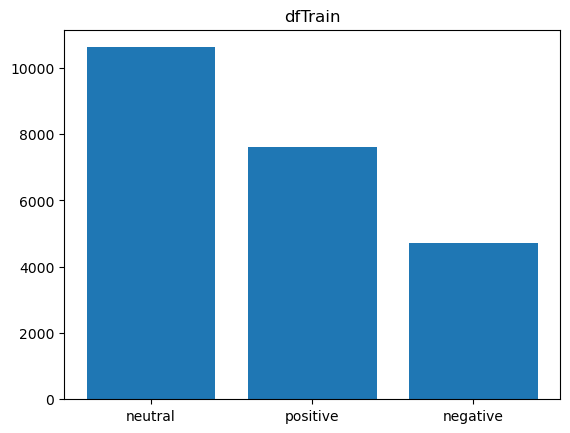

In [20]:
fig, ax = plt.subplots()
plt.title('dfTrain')
ax = plt.bar(['neutral','positive','negative'], dfTrain['Sentiment'].value_counts().values)

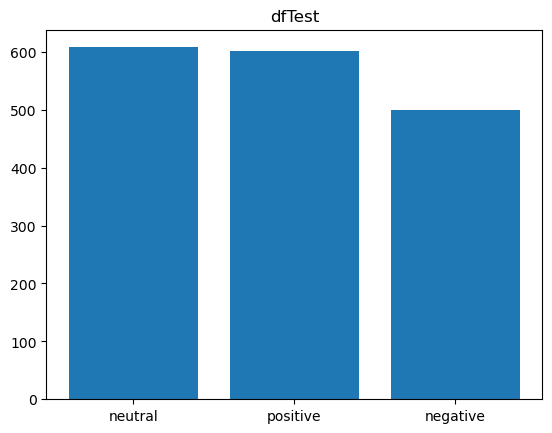

In [21]:
fig, ax = plt.subplots()
plt.title('dfTest')
ax = plt.bar(['neutral','positive','negative'], dfTest['Sentiment'].value_counts().values)

4709


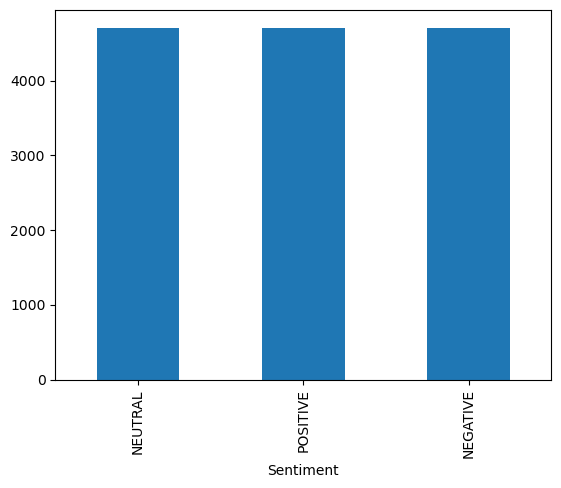

In [23]:
#Class count
count_neutral, count_positive, count_negative = dfTrain.Sentiment.value_counts()
print(count_negative)

#Divide by class
dataset_neutral = dfTrain[dfTrain['Sentiment'] == 'NEUTRAL']
dataset_positive = dfTrain[dfTrain['Sentiment'] == 'POSITIVE']
dataset_negative = dfTrain[dfTrain['Sentiment'] == 'NEGATIVE']

dataset_neutral_under = dataset_neutral.sample(count_negative)
dataset_positive_under = dataset_positive.sample(count_negative)

dataset_balance = pd.concat([dataset_neutral_under, dataset_positive_under, dataset_negative], axis=0)
dataset_balance.Sentiment.value_counts().plot(kind='bar');

In [24]:
# #Split the model into Train and Test Dataset
# X_train, X_test, y_train, y_test = model_selection.train_test_split(dataset_balance['Headline_final'],dataset_balance['Label'],test_size=0.3)


X_train, y_train = dataset_balance['Headline_final'], dataset_balance['Sentiment']
X_test, y_test = dfTest['Headline_final'], dfTest['Sentiment']

In [25]:
#Label encode the target variable
Encoder = LabelEncoder()
y_train = Encoder.fit_transform(y_train)
y_test = Encoder.fit_transform(y_test)

In [26]:
#Vectorize the words by using Tf-Idf Vectorizer
Tfidf_vect = TfidfVectorizer(max_features=5000)
Tfidf_vect.fit(dataset_balance['Headline_final'])
X_train_Tfidf = Tfidf_vect.transform(X_train)


In [27]:
#Classifier - Algorithm - SVM 
#fit the training dataset on the classifier
SVM = svm.SVC(C=1.0, kernel='linear',degree=3, gamma='auto',random_state=42)
SVM.fit(X_train_Tfidf,y_train)

SVC(gamma='auto', kernel='linear', random_state=42)

In [28]:
#predict the labels on validation dataset
X_test_Tfidf = Tfidf_vect.transform(X_test)
predictions_SVM = SVM.predict(X_test_Tfidf)

In [29]:
predictions_SVM

array([1, 2, 2, ..., 1, 0, 2])

In [30]:
#Use accuracy_score function to get the accuracy
print("SVM Accuracy Score -> ",accuracy_score(predictions_SVM,y_test)*100)

SVM Accuracy Score ->  50.43885313048566


In [31]:
from sklearn.metrics import classification_report,confusion_matrix,accuracy_score

#Classification report for tfidf features
svm_tfidf_report=classification_report(y_test,predictions_SVM,target_names=['NEGATIVE','POSITIVE','NEUTRAL'])
print(svm_tfidf_report)

              precision    recall  f1-score   support

    NEGATIVE       0.70      0.42      0.53       601
    POSITIVE       0.39      0.62      0.48       500
     NEUTRAL       0.54      0.49      0.51       608

    accuracy                           0.50      1709
   macro avg       0.54      0.51      0.51      1709
weighted avg       0.55      0.50      0.51      1709



## 2. Polarity detection (positive and negative)
### Train: train_pos_neg.csv, Test: test_pos_neg.csv

#### Training data source: different datasets combined

Both train_pos_neg.csv and test_pos_neg.csv has positive and negative labels

In [2]:
dfTrain = pd.read_csv("train_pos_neg.csv", encoding = 'ISO-8859-1')
dfTest = pd.read_csv("test_pos_neg.csv", encoding = 'ISO-8859-1')

In [3]:
dfTrain.head(3)

,Headline,Sentiment
0,Kickers on my watchlist XIDE TIT SOQ PNK CPW B...,POSITIVE
1,user: AAP MOVIE. 55% return for the FEA/GEED i...,POSITIVE
2,user I'd be afraid to short AMZN - they are lo...,POSITIVE


In [4]:
dfTest['Sentiment'].value_counts()

Sentiment
POSITIVE    608
NEGATIVE    601
Name: count, dtype: int64

In [5]:
dfTrain['Sentiment'].value_counts()

Sentiment
POSITIVE    7609
NEGATIVE    4709
Name: count, dtype: int64

In [6]:
dfTrain.head(3)

,Headline,Sentiment
0,Kickers on my watchlist XIDE TIT SOQ PNK CPW B...,POSITIVE
1,user: AAP MOVIE. 55% return for the FEA/GEED i...,POSITIVE
2,user I'd be afraid to short AMZN - they are lo...,POSITIVE


In [7]:
# remove blank rows if any
dfTrain['Headline'].dropna(inplace=True)
dfTest['Headline'].dropna(inplace=True)

# change headline to lowercase
dfTrain['Headline'] = [headline.lower() for headline in dfTrain['Headline']]
dfTest['Headline'] = [headline.lower() for headline in dfTest['Headline']]

In [8]:
# # download punkt once
# nltk.download("punkt")

In [9]:
# tokenisation
dfTrain['Headline'] = [word_tokenize(headline) for headline in dfTrain['Headline']]
dfTest['Headline'] = [word_tokenize(headline) for headline in dfTest['Headline']]

In [10]:
dfTrain.head(3)

,Headline,Sentiment
0,"[kickers, on, my, watchlist, xide, tit, soq, p...",POSITIVE
1,"[user, :, aap, movie, ., 55, %, return, for, t...",POSITIVE
2,"[user, i, 'd, be, afraid, to, short, amzn, -, ...",POSITIVE


In [11]:
# remove punctuations from token list
dfTrain['Headline'] = [list(filter(lambda token: token not in string.punctuation, tokens)) for tokens in dfTrain['Headline']]
dfTest['Headline'] = [list(filter(lambda token: token not in string.punctuation, tokens)) for tokens in dfTest['Headline']]

In [12]:
dfTrain.head(3)

,Headline,Sentiment
0,"[kickers, on, my, watchlist, xide, tit, soq, p...",POSITIVE
1,"[user, aap, movie, 55, return, for, the, fea/g...",POSITIVE
2,"[user, i, 'd, be, afraid, to, short, amzn, the...",POSITIVE


In [13]:
# # download once
# nltk.download('wordnet')
# nltk.download('averaged_perceptron_tagger')
# nltk.download('stopwords')

In [14]:
#Post Tagging for Train
tag_map = defaultdict(lambda : wn.NOUN)
tag_map['J'] = wn.ADJ
tag_map['V'] = wn.VERB
tag_map['R'] = wn.ADV


# performing lemmatisation
for index, entry in enumerate(dfTrain['Headline']) :
    #Declaring Empty List
    Final_words = []
    #Initializing WordNetLemmatizer()
    word_Lemmatized = WordNetLemmatizer()
    
    for word, tag in pos_tag(entry):
        #Check for Stop words and consider only alphabets
        if word not in stopwords.words('english') and word.isalpha():
            word_Final = word_Lemmatized.lemmatize(word,tag_map[tag[0]])
            Final_words.append(word_Final)
    dfTrain.loc[index,'Headline_final'] = str(Final_words)
    
    
#Post Tagging for Test
tag_map = defaultdict(lambda : wn.NOUN)
tag_map['J'] = wn.ADJ
tag_map['V'] = wn.VERB
tag_map['R'] = wn.ADV


# performing lemmatisation
for index, entry in enumerate(dfTest['Headline']) :
    #Declaring Empty List
    Final_words = []
    #Initializing WordNetLemmatizer()
    word_Lemmatized = WordNetLemmatizer()
    
    for word, tag in pos_tag(entry):
        #Check for Stop words and consider only alphabets
        if word not in stopwords.words('english') and word.isalpha():
            word_Final = word_Lemmatized.lemmatize(word,tag_map[tag[0]])
            Final_words.append(word_Final)
    dfTest.loc[index,'Headline_final'] = str(Final_words)

In [15]:
# dfTrain.to_csv("train_pos_neg_preprocessed.csv", index=False)
# dfTest.to_csv("test_pos_neg_preprocessed.csv", index=False)

In [16]:
dfTrain = pd.read_csv("train_pos_neg_preprocessed.csv", encoding = 'ISO-8859-1')
dfTest = pd.read_csv("test_pos_neg_preprocessed.csv", encoding = 'ISO-8859-1')

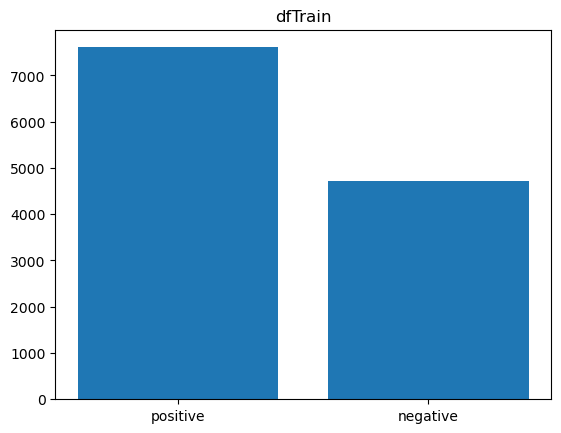

In [17]:
fig, ax = plt.subplots()
plt.title('dfTrain')
ax = plt.bar(['positive','negative'], dfTrain['Sentiment'].value_counts().values)

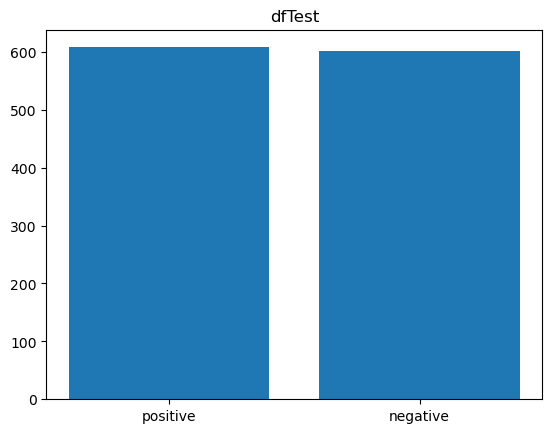

In [18]:
fig, ax = plt.subplots()
plt.title('dfTest')
ax = plt.bar(['positive','negative'], dfTest['Sentiment'].value_counts().values)

4709


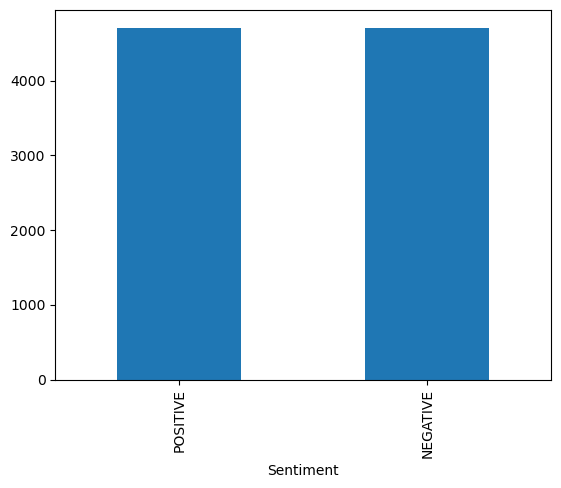

In [19]:
#Class count
count_positive, count_negative = dfTrain.Sentiment.value_counts()
print(count_negative)

#Divide by class
dataset_positive = dfTrain[dfTrain['Sentiment'] == 'POSITIVE']
dataset_negative = dfTrain[dfTrain['Sentiment'] == 'NEGATIVE']

dataset_positive_under = dataset_positive.sample(count_negative)

dataset_balance = pd.concat([dataset_positive_under, dataset_negative], axis=0)
dataset_balance.Sentiment.value_counts().plot(kind='bar');

In [20]:
# #Split the model into Train and Test Dataset
# X_train, X_test, y_train, y_test = model_selection.train_test_split(dataset_balance['Headline_final'],dataset_balance['Label'],test_size=0.3)


X_train, y_train = dataset_balance['Headline_final'], dataset_balance['Sentiment']
X_test, y_test = dfTest['Headline_final'], dfTest['Sentiment']

In [21]:
#Label encode the target variable
Encoder = LabelEncoder()
y_train = Encoder.fit_transform(y_train)
y_test = Encoder.fit_transform(y_test)

In [22]:
#Vectorize the words by using Tf-Idf Vectorizer
Tfidf_vect = TfidfVectorizer(max_features=5000)
Tfidf_vect.fit(dataset_balance['Headline_final'])
X_train_Tfidf = Tfidf_vect.transform(X_train)


In [23]:
#Classifier - Algorithm - SVM 
#fit the training dataset on the classifier
SVM = svm.SVC(C=1.0, kernel='linear',degree=3, gamma='auto',random_state=42)
SVM.fit(X_train_Tfidf,y_train)

SVC(gamma='auto', kernel='linear', random_state=42)

In [24]:
#predict the labels on validation dataset
X_test_Tfidf = Tfidf_vect.transform(X_test)
predictions_SVM = SVM.predict(X_test_Tfidf)

In [25]:
predictions_SVM

array([0, 1, 1, ..., 0, 0, 1])

In [26]:
#Use accuracy_score function to get the accuracy
print("SVM Accuracy Score -> ",accuracy_score(predictions_SVM,y_test)*100)

SVM Accuracy Score ->  72.45657568238212


In [28]:
from sklearn.metrics import classification_report,confusion_matrix,accuracy_score

#Classification report for tfidf features
svm_tfidf_report=classification_report(y_test,predictions_SVM,target_names=['POSITIVE', 'NEGATIVE'])
print(svm_tfidf_report)

              precision    recall  f1-score   support

    POSITIVE       0.77      0.63      0.69       601
    NEGATIVE       0.69      0.82      0.75       608

    accuracy                           0.72      1209
   macro avg       0.73      0.72      0.72      1209
weighted avg       0.73      0.72      0.72      1209



## 3. Subjectivity detection (neutral and opinionated)
### Train: train_neu_opi.csv, Test: test_neu_opi.csv

#### Training data source: different datasets combined

Both train_neu_opi.csv and test_neu_opi.csv has positive and negative labels

In [8]:
dfTrain = pd.read_csv("train_neu_opi.csv", encoding = 'ISO-8859-1')
dfTest = pd.read_csv("test_neu_opi.csv", encoding = 'ISO-8859-1')

In [9]:
dfTrain.head(3)

,Headline,Sentiment
0,Kickers on my watchlist XIDE TIT SOQ PNK CPW B...,OPINIONATED
1,user: AAP MOVIE. 55% return for the FEA/GEED i...,OPINIONATED
2,user I'd be afraid to short AMZN - they are lo...,OPINIONATED


In [10]:
dfTest['Sentiment'].value_counts()

Sentiment
OPINIONATED    1209
NEUTRAL         500
Name: count, dtype: int64

In [11]:
dfTrain['Sentiment'].value_counts()

Sentiment
OPINIONATED    12318
NEUTRAL        10617
Name: count, dtype: int64

In [12]:
dfTrain.head(3)

,Headline,Sentiment
0,Kickers on my watchlist XIDE TIT SOQ PNK CPW B...,OPINIONATED
1,user: AAP MOVIE. 55% return for the FEA/GEED i...,OPINIONATED
2,user I'd be afraid to short AMZN - they are lo...,OPINIONATED


In [13]:
# remove blank rows if any
dfTrain['Headline'].dropna(inplace=True)
dfTest['Headline'].dropna(inplace=True)

# change headline to lowercase
dfTrain['Headline'] = [headline.lower() for headline in dfTrain['Headline']]
dfTest['Headline'] = [headline.lower() for headline in dfTest['Headline']]

In [16]:
# # download punkt once
# nltk.download("punkt")

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\mingj\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping tokenizers\punkt.zip.


True

In [17]:
# tokenisation
dfTrain['Headline'] = [word_tokenize(headline) for headline in dfTrain['Headline']]
dfTest['Headline'] = [word_tokenize(headline) for headline in dfTest['Headline']]

In [18]:
dfTrain.head(3)

,Headline,Sentiment
0,"[kickers, on, my, watchlist, xide, tit, soq, p...",OPINIONATED
1,"[user, :, aap, movie, ., 55, %, return, for, t...",OPINIONATED
2,"[user, i, 'd, be, afraid, to, short, amzn, -, ...",OPINIONATED


In [19]:
# remove punctuations from token list
dfTrain['Headline'] = [list(filter(lambda token: token not in string.punctuation, tokens)) for tokens in dfTrain['Headline']]
dfTest['Headline'] = [list(filter(lambda token: token not in string.punctuation, tokens)) for tokens in dfTest['Headline']]

In [20]:
dfTrain.head(3)

,Headline,Sentiment
0,"[kickers, on, my, watchlist, xide, tit, soq, p...",OPINIONATED
1,"[user, aap, movie, 55, return, for, the, fea/g...",OPINIONATED
2,"[user, i, 'd, be, afraid, to, short, amzn, the...",OPINIONATED


In [21]:
# # download once
# nltk.download('wordnet')
# nltk.download('averaged_perceptron_tagger')
# nltk.download('stopwords')

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\mingj\AppData\Roaming\nltk_data...
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\mingj\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping taggers\averaged_perceptron_tagger.zip.
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\mingj\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping corpora\stopwords.zip.


True

In [22]:
#Post Tagging for Train
tag_map = defaultdict(lambda : wn.NOUN)
tag_map['J'] = wn.ADJ
tag_map['V'] = wn.VERB
tag_map['R'] = wn.ADV


# performing lemmatisation
for index, entry in enumerate(dfTrain['Headline']) :
    #Declaring Empty List
    Final_words = []
    #Initializing WordNetLemmatizer()
    word_Lemmatized = WordNetLemmatizer()
    
    for word, tag in pos_tag(entry):
        #Check for Stop words and consider only alphabets
        if word not in stopwords.words('english') and word.isalpha():
            word_Final = word_Lemmatized.lemmatize(word,tag_map[tag[0]])
            Final_words.append(word_Final)
    dfTrain.loc[index,'Headline_final'] = str(Final_words)
    
    
#Post Tagging for Test
tag_map = defaultdict(lambda : wn.NOUN)
tag_map['J'] = wn.ADJ
tag_map['V'] = wn.VERB
tag_map['R'] = wn.ADV


# performing lemmatisation
for index, entry in enumerate(dfTest['Headline']) :
    #Declaring Empty List
    Final_words = []
    #Initializing WordNetLemmatizer()
    word_Lemmatized = WordNetLemmatizer()
    
    for word, tag in pos_tag(entry):
        #Check for Stop words and consider only alphabets
        if word not in stopwords.words('english') and word.isalpha():
            word_Final = word_Lemmatized.lemmatize(word,tag_map[tag[0]])
            Final_words.append(word_Final)
    dfTest.loc[index,'Headline_final'] = str(Final_words)

In [23]:
# dfTrain.to_csv("train_neu_opi_preprocessed.csv", index=False)
# dfTest.to_csv("test_neu_opi_preprocessed.csv", index=False)

In [29]:
dfTrain = pd.read_csv("train_neu_opi_preprocessed.csv", encoding = 'ISO-8859-1')
dfTest = pd.read_csv("test_neu_opi_preprocessed.csv", encoding = 'ISO-8859-1')

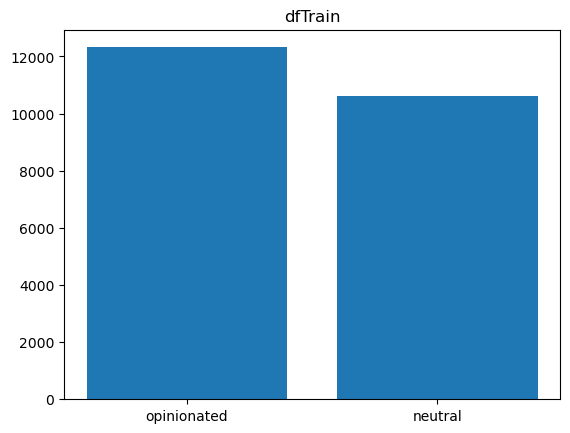

In [30]:
fig, ax = plt.subplots()
plt.title('dfTrain')
ax = plt.bar(['opinionated', 'neutral'], dfTrain['Sentiment'].value_counts().values)

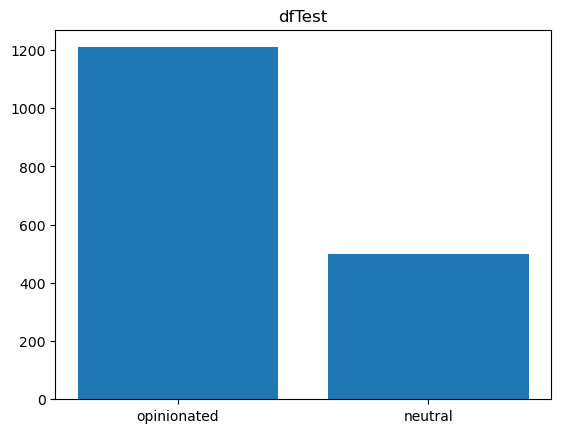

In [31]:
fig, ax = plt.subplots()
plt.title('dfTest')
ax = plt.bar(['opinionated', 'neutral'], dfTest['Sentiment'].value_counts().values)

10617


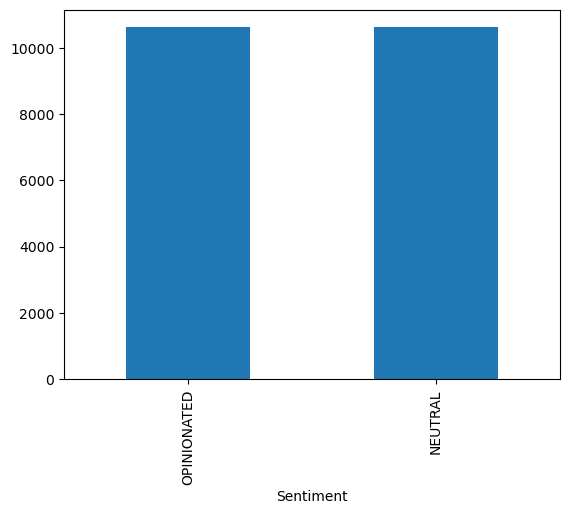

In [32]:
#Class count
count_opinionated, count_neutral = dfTrain.Sentiment.value_counts()
print(count_neutral)

#Divide by class
dataset_opinionated = dfTrain[dfTrain['Sentiment'] == 'OPINIONATED']
dataset_neutral = dfTrain[dfTrain['Sentiment'] == 'NEUTRAL']

dataset_opinionated_under = dataset_opinionated.sample(count_neutral)

dataset_balance = pd.concat([dataset_opinionated_under, dataset_neutral], axis=0)
dataset_balance.Sentiment.value_counts().plot(kind='bar');

In [33]:
# #Split the model into Train and Test Dataset
# X_train, X_test, y_train, y_test = model_selection.train_test_split(dataset_balance['Headline_final'],dataset_balance['Label'],test_size=0.3)


X_train, y_train = dataset_balance['Headline_final'], dataset_balance['Sentiment']
X_test, y_test = dfTest['Headline_final'], dfTest['Sentiment']

In [34]:
#Label encode the target variable
Encoder = LabelEncoder()
y_train = Encoder.fit_transform(y_train)
y_test = Encoder.fit_transform(y_test)

In [35]:
#Vectorize the words by using Tf-Idf Vectorizer
Tfidf_vect = TfidfVectorizer(max_features=5000)
Tfidf_vect.fit(dataset_balance['Headline_final'])
X_train_Tfidf = Tfidf_vect.transform(X_train)


In [36]:
#Classifier - Algorithm - SVM 
#fit the training dataset on the classifier
SVM = svm.SVC(C=1.0, kernel='linear',degree=3, gamma='auto',random_state=42)
SVM.fit(X_train_Tfidf,y_train)

SVC(gamma='auto', kernel='linear', random_state=42)

In [37]:
#predict the labels on validation dataset
X_test_Tfidf = Tfidf_vect.transform(X_test)
predictions_SVM = SVM.predict(X_test_Tfidf)

In [38]:
predictions_SVM

array([0, 0, 1, ..., 0, 1, 1])

In [39]:
#Use accuracy_score function to get the accuracy
print("SVM Accuracy Score -> ",accuracy_score(predictions_SVM,y_test)*100)

SVM Accuracy Score ->  55.58806319485079


In [40]:
from sklearn.metrics import classification_report,confusion_matrix,accuracy_score

#Classification report for tfidf features
svm_tfidf_report=classification_report(y_test,predictions_SVM,target_names=['OPINIONATED','NEUTRAL'])
print(svm_tfidf_report)

              precision    recall  f1-score   support

 OPINIONATED       0.36      0.68      0.47       500
     NEUTRAL       0.79      0.50      0.62      1209

    accuracy                           0.56      1709
   macro avg       0.58      0.59      0.54      1709
weighted avg       0.67      0.56      0.57      1709



Accuracy: 0.564072557050907
